# DV2607 Project Notebook
### Authors:
### Oliver Ljung (ollj19@student.bth.se)
### Phoebe Waters (phaa19@student.bth.se)

## Importing modules and dataset

In [24]:
# imports
from matplotlib import pyplot as plt
import numpy as np

import tensorflow as tf

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Activation, BatchNormalization, LeakyReLU, Reshape, UpSampling2D, Dropout
from keras import Sequential, Model
from keras.datasets import mnist
from keras.utils import to_categorical
from tensorflow.keras.preprocessing import image

import random

## Defining functions

In [25]:
# Defining functions

def create_classifier():
    # Create a CNN model
    model = Sequential()

    # Add Convolution layers
    model.add(Conv2D(28, (3,3), activation='relu', input_shape=(28,28,1)))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(56, (3,3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(56, (3,3), activation='relu'))

    model.add(Flatten())

    # Add predictive layers
    model.add(Dense(56, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
    print(model.summary())

    # Add input
    input = Input(shape = (28,28,1))

    # Get ouput from model
    prediction = model(input)

    return Model(input, prediction)

def create_generator():
    # Create a CNN model
    model = Sequential()

    model.add(Dense(7*7*28, activation='relu', input_dim=100))
    model.add(Reshape((7,7,28)))

    model.add(UpSampling2D())
    model.add(Conv2D(28, (3,3), activation='relu', padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU())

    model.add(UpSampling2D())
    model.add(Conv2D(56, (3,3), activation='relu', padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU())
    
    model.add(Conv2D(1, (3,3), activation='relu', padding="same"))
    model.add(Activation('tanh'))

    print(model.summary())

    input = Input(shape = (100))
    
    img = model(input)
    
    return Model(input, img)

def create_adv_generator():
    # Create a CNN model
    model = Sequential()

    model.add(Conv2D(28, (3,3), activation='relu', padding="same", input_shape=(28,28,1)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(28, (3,3), activation='relu', padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU())

    model.add(UpSampling2D())
    model.add(Conv2D(56, (3,3), activation='relu', padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU())
    
    model.add(Conv2D(1, (3,3), activation='relu', padding="same"))
    model.add(Activation('tanh'))

    print(model.summary())

    input = Input(shape = (28,28,1))
    
    img = model(input)
    
    return Model(input, img)

def create_discriminator():
    # Create a CNN model
    model = Sequential()

    # Add Convolution layers
    model.add(Conv2D(28, (3,3), activation='relu', input_shape=(28,28,1)))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(56, (3,3), activation='relu'))

    model.add(Flatten())

    # Add predictive layers
    model.add(Dense(56, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    print(model.summary())

    # Add input
    input = Input(shape = (28,28,1))

    # Get ouput from model
    validity = model(input)

    return Model(input, validity)

## Loading dataset

In [26]:
# load dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()

train_X = train_X.astype("float32") / 255
test_X = test_X.astype("float32") / 255

train_X = np.expand_dims(train_X, -1)
test_X = np.expand_dims(test_X, -1)

train_y = to_categorical(train_y)
test_y  = to_categorical(test_y)

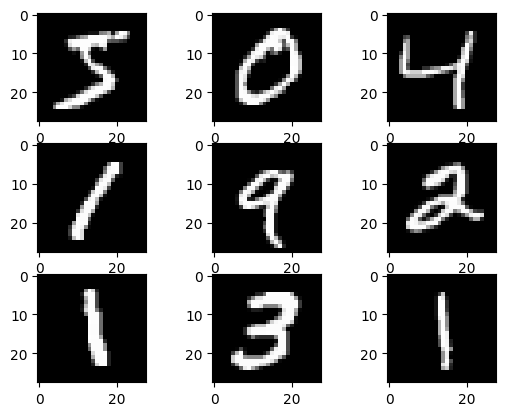

In [27]:
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))
plt.show()

## Training the Classifier; model to attack and later defend

In [28]:
optimizer = tf.optimizers.Adam()

model = create_classifier()
model.compile(optimizer=optimizer, loss=["categorical_crossentropy"], metrics=["accuracy"])

model.fit(train_X, train_y)
model.save("classifier.h5")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 26, 26, 28)        280       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 28)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 11, 11, 56)        14168     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 56)         0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 3, 3, 56)          28280     
                                                                 
 flatten_2 (Flatten)         (None, 504)              

KeyboardInterrupt: 

In [ ]:
model.predict(np.array([test_X[0]]))
# test_X[0].shape

1/1 [==============================] - 0s 60ms/step


array([[9.0487319e-08, 2.9976231e-08, 3.3031135e-06, 1.0775769e-06,
        1.9819606e-09, 1.9080335e-07, 1.0606306e-12, 9.9999380e-01,
        2.7945194e-07, 1.2468917e-06]], dtype=float32)

### Model baseline

In [ ]:
model.evaluate(test_X, test_y)

313/313 [==============================] - 2s 5ms/step - loss: 0.0601 - accuracy: 0.9816


[0.060132160782814026, 0.9815999865531921]

## Defining models and input tensors

In [ ]:
optimizer = tf.optimizers.Adam()

adv_generator = create_adv_generator()
input = Input(shape=(28,28,1))
img_perturbed = adv_generator(input)

# We want the generator and discriminator to be trained in a combined model but as seperate entities
discriminator = create_discriminator()
discriminator.compile(optimizer=optimizer, loss=["binary_crossentropy"], metrics=["accuracy"])
discriminator.trainable = False 
validity = discriminator(img_perturbed)

model.trainable = False
prediction = model(img_perturbed)

GAN_model = Model(input, (validity, prediction))
GAN_model.compile(optimizer=optimizer, loss=["binary_crossentropy"], metrics=["accuracy"])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 28)        280       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 28)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 28)        7084      
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 28)       112       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 28)        0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 28, 28, 28)      

## AdvGAN Training

In [ ]:
BATCH_SIZE = 32
EPOCHS = 10_000

y_real = np.ones((BATCH_SIZE, 1))
y_fake = np.zeros((BATCH_SIZE, 1))

for epoch in range(EPOCHS):
    print(f"EPOCH: {epoch}")
    x_real = np.array(random.choices(train_X, k=BATCH_SIZE))
    
    x_fake = adv_generator.predict(x_real)
    x_fake_labels = model.predict(x_fake)

    discriminator.train_on_batch(x=x_real, y=y_real)
    discriminator.train_on_batch(x=x_fake, y=y_fake)
    GAN_model.train_on_batch(x=x_real, y=(y_real, x_fake_labels))

adv_generator.save("mnist_adv_generator.h5")
discriminator.save("mnist_adv_discriminator.h5")

EPOCH: 0
1/1 [==============================] - 0s 97ms/step
EPOCH: 1
1/1 [==============================] - 0s 30ms/step
EPOCH: 2
1/1 [==============================] - 0s 27ms/step
EPOCH: 3
1/1 [==============================] - 0s 28ms/step
EPOCH: 4
1/1 [==============================] - 0s 29ms/step
EPOCH: 5
1/1 [==============================] - 0s 27ms/step
EPOCH: 6
1/1 [==============================] - 0s 26ms/step
EPOCH: 7
1/1 [==============================] - 0s 40ms/step
EPOCH: 8
1/1 [==============================] - 0s 27ms/step
EPOCH: 9
1/1 [==============================] - 0s 28ms/step
EPOCH: 10
1/1 [==============================] - 0s 27ms/step
EPOCH: 11
1/1 [==============================] - 0s 27ms/step
EPOCH: 12
1/1 [==============================] - 0s 27ms/step
EPOCH: 13
1/1 [==============================] - 0s 25ms/step
EPOCH: 14
1/1 [==============================] - 0s 25ms/step
EPOCH: 15
1/1 [==============================] - 0s 27ms/step
EPOCH: 16
1/1 [===

KeyboardInterrupt: 

1/1 [==============================] - 0s 33ms/step
p = 5
p = 6
p = 4
p = 9
p = 5
p = 5
p = 9
p = 6
p = 0


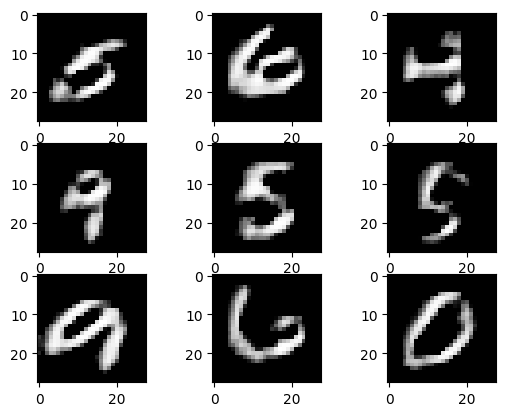

In [ ]:
x_real = np.array(random.choices(train_X, k=BATCH_SIZE))
x_fake = adv_generator.predict(x_real)
x_fake_labels = model.predict(x_fake)

for i in range(9):
    fig = plt.subplot(3, 3, i+1)
    plt.imshow(x_fake[i], cmap=plt.get_cmap('gray'))
    print(f'p = {np.argmax(x_fake_labels[i])}')
plt.show()